We'll start with some common imports  

In [1]:
from pathlib import Path
import pathlib
import numpy as np
import shutil
import os
import pandas as pd

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 15)
import cv2

from pandas.core.common import random_state
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier



from skimage.feature import greycomatrix, greycoprops
from skimage import data

from numpy import sort
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, auc
from sklearn import metrics
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel,RFECV
import csv 

In [19]:
DATA_PATH = "/home/saqib/Plantar_Thermogram_Diabetes_Project/data"
IMG_PATH = DATA_PATH + "/CompressedData"
CSV_FILE_PATH = DATA_PATH + "/csvs/mlfeatures/"
UPDATE_FILE_PATH = DATA_PATH + "/updates/"


In [20]:
from numpy import loadtxt
from numpy import sort
from joblib import dump, load
import pickle


def load_and_process(filename, filename2):
  raw_df_all = pd.read_csv(CSV_FILE_PATH+filename, index_col=[0])
  # raw_df_all = raw_df_all.rename(columns={"RIGHT FOOT":"Overall Mean(Right)", "LEFT FOOT":"Overall Mean(Left)","IMC":"BMI"})
  # raw_df_all = raw_df_all.drop(columns=["Age (years)","Overall Mean(Right)"])

  #Right
  raw_df_all_R = pd.read_csv(CSV_FILE_PATH+filename2, index_col=[0])
  # raw_df_all_R = raw_df_all_R.rename(columns={"RIGHT FOOT":"Overall Mean(Right)", "LEFT FOOT":"Overall Mean(Left)","IMC":"BMI"})
  # raw_df_all_R = raw_df_all_R.drop(columns=["Age (years)","Overall Mean(Right)"])

  return (raw_df_all, raw_df_all_R)

  
def load_and_process(filename):
  raw_df_all = pd.read_csv(CSV_FILE_PATH+filename, index_col=[0])
  # raw_df_all = raw_df_all.rename(columns={"RIGHT FOOT":"Overall Mean(Right)", "LEFT FOOT":"Overall Mean(Left)","IMC":"BMI"})
  # raw_df_all = raw_df_all.drop(columns=["Age (years)","Overall Mean(Right)"])

  return raw_df_all

def save_classifier(clf, filename):
  s = pickle.dumps(clf)
  dump(clf,f'{CSV_FILE_PATH}{filename}.joblib') 
  print(f"Best clf saved as {filename}")

def load_classifier(filename):
  clf = load(f'{CSV_FILE_PATH}{filename}.joblib') 
  return clf


In [21]:
import seaborn as sns
def plot_heatmap(dataframe, title="Coorelation of extracted features"):
  '''
  Plot heatmap of values in given dataframe

  Inputs: 
      dataframe: features dataframe
      title: Title of the figure produced

  Output: 
      dataframe that contains only the non-highly-collinear features
  '''
  Var_Corr = dataframe.corr()
  # plot the heatmap and annotation on it
  sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)
  plt.title(title)
  plt.show()

def drop_correlated_features(df, thresh=0.95, low_thresh=-0.5):
  '''
  Remove collinear features in a dataframe with a correlation coefficient
  greater than the threshold. Removing collinear features can help a model 
  to generalize and improves the interpretability of the model.

  Inputs: 
      df: features dataframe
      thresh: features with correlations greater than this value are removed
      low_thresh: features with correlations less than this value are removed

  Output: 
      dataframe that contains only the non-highly-collinear features
  '''

  # Create correlation matrix
  corr_matrix = df.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  # Find features with correlation greater than 0.95
  to_drop = [column for column in upper.columns if any(upper[column] > thresh) or any(upper[column] < low_thresh)]
  print(f'Initial Features: {len(df.columns)} Features left: {len(df.columns) - len(to_drop)} Dropped:{len(to_drop)}')
  # Drop features 
  return df.drop(to_drop, axis=1, inplace=False)

def write_to_csv(file_name, fields, rows):
  '''
    Input: 
      file_name = Name of the file,
      fields = the columns of the table
      rows = the input rows of the table
    Output: 
  '''
      
  # name of csv file 
  filename = f"{CSV_FILE_PATH}/Results/{file_name}.csv"

  
  # writing to csv file 
  with open(filename, 'w') as csvfile: 
      # creating a csv writer object 
      csvwriter = csv.writer(csvfile) 
          
      # writing the fields 
      csvwriter.writerow(fields) 
          
      # writing the data rows 
      csvwriter.writerows(rows)
      
  print(f"Successfully written to {filename}")

def drop_correlated(df1, df2, thresh=0.80):
  raw_df = drop_correlated_features(df1, thresh,-0.1)
  raw_df_R = df2[raw_df.columns]
  print("Features: ", len(raw_df.columns))
  plot_heatmap(df1.drop(columns=["label"], inplace=False), title="Correlation of all extracted features")
  plot_heatmap(drop_correlated_features(df1.drop(columns=["label"], inplace=False), thresh, -0.2), title="Correlation of extracted features (threshold > 0.85 dropped)")
  return raw_df, raw_df_R

def drop_correlated(df1, thresh=0.80):
  raw_df = drop_correlated_features(df1, thresh,-0.1)
  print("Features: ", len(raw_df.columns))
  plot_heatmap(df1.drop(columns=["label"], inplace=False), title="Correlation of all extracted features")
  plot_heatmap(drop_correlated_features(df1.drop(columns=["label"], inplace=False), thresh, -0.2), title="Correlation of extracted features (threshold > 0.85 dropped)")
  return raw_df


In [22]:
def div_train_test(ldf, rdf):
  X_test = rdf[rdf.columns[:-1]].fillna(method="pad") # Features
  y_test = rdf.label.fillna(method="pad") # Target variable

  X_raw = ldf[X_test.columns].fillna(method="pad") # Features
  y_raw = ldf.label.fillna(method="pad") # Target variable

  print(f'X shape {X_raw.shape}, y shape {y_raw.shape}')
  print(f'Xtest shape {X_test.shape}, ytest shape {y_test.shape}')
  return X_test, y_test, X_raw, y_raw


def data_load_split(df, train=0.7, val= 0.2, test=0.1):
  X = df[df.columns[:-1]].fillna(method="pad") # Features
  y = df.label.fillna(method="pad") # Target variable

  # Split train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
  
  # Scale values 
  # X_train, X_test = scale_and_normalize(X,X_test)
  
  # Split train into val sets
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

  return (X_train,y_train, X_val, y_val, X_test, y_test)

# Scale and Normalize
from sklearn import preprocessing
def scale_and_normalize(X, X_test):
    
  x = X.values 
  xt = X_test.values

  cols = X.columns
  testcols = X_test.columns

  min_max_scaler = preprocessing.MinMaxScaler()

  scaler = min_max_scaler.fit(x)
  x_scaled = scaler.transform(x)
  x_test_scaled = scaler.transform(xt)

  X = pd.DataFrame(x_scaled, columns=cols)
  X_test = pd.DataFrame(x_test_scaled, columns=testcols)
  print(X.tail())
  print(X_test.tail())

  return(X, X_test)

def scale_and_normalize(X, X_val, X_test):
    
  x = X.values 
  xv = X_val.values
  xt = X_test.values

  cols = X.columns
  vcols =X_val.columns
  testcols = X_test.columns

  min_max_scaler = preprocessing.MinMaxScaler()

  scaler = min_max_scaler.fit(x)
  x_scaled = scaler.transform(x)
  x_val_scaled = scaler.transform(xv)
  x_test_scaled = scaler.transform(xt)

  X = pd.DataFrame(x_scaled, columns=cols)
  X_val = pd.DataFrame(x_val_scaled, columns = vcols)
  X_test = pd.DataFrame(x_test_scaled, columns=testcols)

  return(X,X_val,X_test)  



/tmp/ipykernel_6020/1751828769.py:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


Initial Features: 71 Features left: 50 Dropped:21
Features:  50


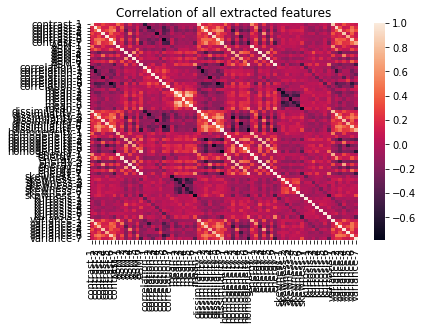

/tmp/ipykernel_6020/1751828769.py:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


Initial Features: 70 Features left: 49 Dropped:21


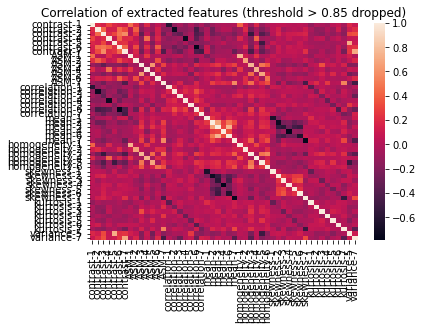

In [23]:

sizes = ["100.0", "110.0", "120.0", "130.0", "140.0"]
orient = ["LEFT"]
augs = ["AUG", "AUG1"]
def get_data():
  filearr = []
  for aug in augs:
    for s in sizes:
      for o in orient:
        file = f"{o}-{s}-FEATURES-{aug}.csv"
        filearr.append(file)
  return filearr
files = get_data()

  # Load Data
# ldf, rdf = load_and_process(files[0], files[0])
ldf = load_and_process("LEFT-140.0-FEATURES-AUG.csv")
df = drop_correlated(ldf)
#X_test, y_test, X, y = div_train_test(ldf, rdf)

X_train, y_train, X_val, y_val, X_test, y_test = data_load_split(df) 
X_train, X_val, X_test = scale_and_normalize(X_train, X_val, X_test)


In [24]:
def plot_feature_importances(importances, features_names):
  # Print the feature ranking
  print("Feature ranking:")

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(len(features_names)), importances[range(0, len(importances))], color="g", align="center")
  plt.xticks(range(len(features_names)),features_names,rotation=90)
  plt.xlim([-1, len(features_names)])
  plt.show()

def select_features(model, X, y, plot=False):
  if(not model):
    model = RandomForestClassifier(n_estimators = 100)
  sel = SelectFromModel(model)
  sel.fit(X, y)
  selected_feat= X.columns[(sel.get_support())]
  print(f'Selected Features: {len(selected_feat)} Names: ', selected_feat)
  print(len(sel.estimator_.feature_importances_.ravel()))
  if(plot):
    plot_feature_importances(sel.estimator_.feature_importances_.ravel(), X.columns)

#select_features(None, X, y, plot=True)

In [25]:
def recursive_feat_elim(model, X, y):
  if(not model):
    model = RandomForestClassifier(n_estimators = 100)
  # The "accuracy" scoring shows the proportion of correct classifications

  min_features_to_select = 1  # Minimum number of features to consider
  rfecv = RFECV(
      estimator=model,
      step=1,
      cv=StratifiedKFold(2),
      scoring="accuracy",
      min_features_to_select=min_features_to_select,
  )
  rfecv.fit(X, y)

  print("Optimal number of features : %d" % rfecv.n_features_)

  # Plot number of features VS. cross-validation scores
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  plt.plot(
      range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
      rfecv.grid_scores_,
  )
  plt.show()

  # Optimal features
  selected_feat= X.columns[(rfecv.support_)]
  print(selected_feat)

In [26]:
# # Split X and y into training and testing sets

# X_train,X_val,y_train,y_val=train_test_split(X[X_test.columns],y,test_size=0.0001, shuffle=True)
# print(X_train.shape[0], X_train.shape[1], X_test.shape[0], X_test.shape[1], y_test.shape[0])

fields = ["K-folds", "CV Accuracy", "ROC-AUC Score", "Precision", "Recall", "Test Accuracy", "Test Precision", "Test Recall", "Test ROC-AUC"]

In [27]:
from sklearn.inspection import permutation_importance
def plot_rf_feat_imp(forest, X_test, y_test):
  feature_names = X_test.columns
  result = permutation_importance(
      forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
  )
  forest_importances = pd.Series(result.importances_mean, index=feature_names)

  fig, ax = plt.subplots()
  forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
  ax.set_title("Feature importances using permutation on full model")
  ax.set_ylabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score


models_to_test = [AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, XGBClassifier]
models_for_fs = [RandomForestClassifier, ExtraTreesClassifier, Lasso]


def calculate_cv_scores(cv, model, X_train, y_train):
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
  precision = cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1)
  roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  recall = cross_val_score(model, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
  return (scores, precision, roc_auc, recall)

def plot_recurse_feat_selection(features, accuracy, roc):
  plt.figure()
  plt.title("CV accuracy for different number of features")
  plt.ylabel("Mean CV Accuracues")
  plt.xlabel("Features selected")
  plt.plot(features,accuracy, 'go--', linewidth=2, markersize=12)


  plt.figure()
  plt.title("CV ROC for different number of features")
  plt.ylabel("Mean ROC Score")
  plt.xlabel("Features selected")
  plt.plot(features,roc, 'ro--', linewidth=2, markersize=12)



def recursive_feat_selection(model,X_train,y_train, X_test_feat, y_test):
  features = []
  test_accuracies = []
  test_roc = []
  test_precision = []

  rows = []
  fields = ["Features Selected", "CV Accuracy", "ROC-AUC Score", "Precision", "Recall"]

  # make predictions for test data and evaluate
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  roc = roc_auc_score(y_test, predictions)


  
  # Calculate CV score
  cv = KFold(n_splits=5, shuffle=True)
  scores, precision, roc_auc, recall = calculate_cv_scores(cv, model, X_train, y_train)

  features.append(len(X_train.columns))
  test_accuracies.append(np.mean(scores))
  test_roc.append(np.mean(roc_auc))
  test_precision.append(np.mean(precision))

  print("Accuracy: %.2f%%" % (np.mean(scores) * 100.0))
  rows.append([len(X_train.columns), np.mean(scores), np.mean(roc_auc), np.mean(precision), np.mean(recall)])


  # Fit model using each importance as a threshold
  thresholds = sort(model.feature_importances_)
  for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test_feat)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)

    scores, precision, roc_auc, recall = calculate_cv_scores(cv, model, X_train, y_train)
    features.append(select_X_train.shape[1])
    test_accuracies.append(np.mean(scores))
    test_roc.append(np.mean(roc_auc))
    test_precision.append(np.mean(precision))

    # Write to csv file
    rows.append([select_X_train.shape[1], np.mean(scores), np.mean(roc_auc), np.mean(precision), np.mean(recall)])
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], np.mean(scores)*100.0))
  write_to_csv("xgb-recursive-fs", fields, rows)
  plot_recurse_feat_selection(features, test_accuracies, test_roc)

### CROSS VALIDATION K-FOLD

In [ ]:
from gc import callbacks
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report,plot_roc_curve, RocCurveDisplay

#Wand DB Init
# import wandb
# from wandb.xgboost import wandb_callback

def get_param_grid(name):
  '''
  Get cross validation parameter grid based on model type.
  Input:
    name : The name of the model, either 'XGB' | 'RF' | 'ET'
  Output:
    dict containing the param grid

  '''
  if(name == "xgb"):

    return { 'max_depth': [2, 3, 4, 5],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'subsample': np.arange(0.1, 0.5, 0.1),
              'alpha': np.arange(2.5, 2.8, 0.1),
              'gamma': np.arange(4.5, 5.5, 0.1),
              'lambda': np.arange(0.6, 1.0, 0.1),
              'colsample_bytree': np.arange(0.1, 0.6, 0.1),
              'colsample_bylevel': np.arange(0.1, 0.5, 0.1),
              'n_estimators': [20, 50, 80,120] 
           }
  if(name == "RF"):
    return {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600]}

def model_train(model_test, X_train, y_train, X_test, y_test, param_name="xgb", 
                filename="test.csv", recurse=False, kfolds=[5,10], grid_search = False):
  
  '''
  Train and evaluate cross validation of model.
  Input:
    model : The model used for training
    param_name : The name of the model, either 'xgb' | 'rf' | 'et'

  '''
  
  # wandb.init(project="test-project", entity="sqbislam") 
  params = get_param_grid(param_name)
  row = []
  for i in kfolds:

    cv = StratifiedKFold(n_splits=i, shuffle=True)
    
    model = model_test

    if(grid_search == True):
      model=GridSearchCV(estimator=model,
                        param_grid=params,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=cv,
                        verbose=1)
    else:
      model=RandomizedSearchCV(estimator=model,
                            param_distributions=params,
                            scoring='accuracy',
                            n_iter=200,
                            cv=cv,
                            verbose=1)
    # Fit Model
    model.fit(X_train, y_train)
    y2 = model.predict(X_test)

    # Calculate CV score
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    precision = cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1)
    recall = cross_val_score(model, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
    roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

    #Extract feature importance
    output = cross_validate(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_estimator =True)
    feature_importances = extract_feat_importance(output, X_train.columns)
    
    # test eval metrics
    test_acc = accuracy_score(y_test,y2)
    test_recall = recall_score(y_test,y2)
    test_precision = precision_score(y_test,y2)
    test_roc = roc_auc_score(y_test,y2)
    

    cv_results = model.cv_results_

    val_metrics = {"K-fold": i, 
                   "CV_accuracy": scores,
                   "CV_ROC": roc_auc,
                   "CV_Precision":precision,
                   "CV_Recall":recall,
                   "Test_Accuracy":test_acc,
                   "Test_Precision":test_precision,
                   "Test_Recall":test_recall,
                   "Test_ROC":test_roc
                   }
    # wandb.log({**val_metrics, **cv_results})

    # report performance
    cv_acc = "{:.3f} ({:.3f})".format(np.mean(scores), np.std(scores))
    roc = "{:.3f} ({:.3f})".format(np.mean(roc_auc), np.std(roc_auc))
    recall = "{:.3f} ({:.3f})".format(np.mean(recall), np.std(recall))
    precision = "{:.3f} ({:.3f})".format(np.mean(precision), np.std(precision))

    test_acc =  "{:.3f} ({:.3f})".format(np.mean(test_acc), np.std(test_acc))
    test_rec =  "{:.3f} ({:.3f})".format(np.mean(test_recall), np.std(test_recall))
    test_prec = "{:.3f} ({:.3f})".format(np.mean(test_precision), np.std(test_precision))
    test_roc = "{:.3f} ({:.3f})".format(np.mean(test_roc), np.std(test_roc))
    row.append([i,cv_acc, roc, precision, recall, test_acc, test_prec, test_rec, test_roc])
   


  
    print(model.best_estimator_)
    print('CV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    print('CV Mean ROC: ', roc)
    print("Test Accuracy: ", test_acc)
    print("Test ROC: ", test_roc)

    if(recurse==True):
      recursive_feat_selection(model.best_estimator_, X_train, y_train, X_test, y_test)
    # plot_roc_cv(model.best_estimator_, X_raw.values, y_raw.values)
    
    # Save to csv if available
    if(filename):
      write_to_csv(file_name=filename, fields=fields, rows=row)
    
  # wandb.finish()
  return (model.best_estimator_, feature_importances)
    # plot_rf_feat_imp(model.best_estimator_, X_test, y_test)

In [ ]:
model = XGBClassifier(gamma=3.0, alpha=1.2)
# model = RandomForestClassifier()
best_est, feat_imp = model_train(model,X_train,y_train,X_test,y_test, recurse=False,kfolds=[5], filename=None)

### TRAIN TEST VAL SPLIT

In [29]:
from gc import callbacks
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report,plot_roc_curve, RocCurveDisplay

#Wand DB Init
# import wandb
# from wandb.xgboost import wandb_callback
fields = ["K-folds", "CV Accuracy", "ROC-AUC Score", "Precision", "Recall", 
          "Val Accuracy", "Val Precision", "Val Recall", "Val ROC-AUC",
          "Test Accuracy", "Test Precision", "Test Recall", "Test ROC-AUC"]

def get_param_grid(name):
  '''
  Get cross validation parameter grid based on model type.
  Input:
    name : The name of the model, either 'XGB' | 'RF' | 'ET'
  Output:
    dict containing the param grid

  '''
  if(name == "xgb"):

    return { 'max_depth': [2, 3, 4, 5],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'subsample': np.arange(0.1, 0.5, 0.1),
              'alpha': np.arange(2.5, 2.8, 0.1),
              'gamma': np.arange(4.5, 5.5, 0.1),
              'lambda': np.arange(0.6, 1.0, 0.1),
              'colsample_bytree': np.arange(0.1, 0.6, 0.1),
              'colsample_bylevel': np.arange(0.1, 0.5, 0.1),
              'n_estimators': [20, 50, 80,120] 
           }
  if(name == "RF"):
    return {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600]}

def model_train_tts(model_test, X_train, y_train, X_val, y_val, X_test, y_test, param_name="xgb", 
                filename="test.csv",dump_file=None, recurse=False, kfolds=[5], grid_search = False):
  
  '''
  Train and evaluate cross validation of model.
  Input:
    model : The model used for training
    param_name : The name of the model, either 'xgb' | 'rf' | 'et'

  '''
  
  # wandb.init(project="test-project", entity="sqbislam") 
  params = get_param_grid(param_name)
  row = []
  for i in kfolds:

    cv = StratifiedKFold(n_splits=i, shuffle=True)
    
    model = model_test

    if(grid_search == True):
      model=GridSearchCV(estimator=model,
                        param_grid=params,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=cv,
                        verbose=1)
    else:
      model=RandomizedSearchCV(estimator=model,
                            param_distributions=params,
                            scoring='accuracy',
                            n_iter=200,
                            cv=cv,
                            verbose=1)
    # Fit Model
    model.fit(X_train, y_train)

    # Predict train, val and test
    yt = model.predict(X_train)
    y2 = model.predict(X_test)
    yv = model.predict(X_val)


    # Calculate CV score
    # scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # precision = cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1)
    # recall = cross_val_score(model, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
    # roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

    # Calculate Train Score
    scores = accuracy_score(y_train,yt)
    precision = recall_score(y_train,yt)
    recall = precision_score(y_train,yt)
    roc_auc = roc_auc_score(y_train,yt)

    #Extract feature importance
    output = cross_validate(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, return_estimator =True)
    feature_importances = extract_feat_importance(output, X_train.columns)


    # val eval metrics
    val_acc = accuracy_score(y_val,yv)
    val_recall = recall_score(y_val,yv)
    val_precision = precision_score(y_val,yv)
    val_roc = roc_auc_score(y_val,yv)

    # test eval metrics
    test_acc = accuracy_score(y_test,y2)
    test_recall = recall_score(y_test,y2)
    test_precision = precision_score(y_test,y2)
    test_roc = roc_auc_score(y_test,y2)
    

    cv_results = model.cv_results_

    val_metrics = {"K-fold": i, 
                   "CV_accuracy": scores,
                   "CV_ROC": roc_auc,
                   "CV_Precision":precision,
                   "CV_Recall":recall,
                   "Val_Accuracy":val_acc,
                   "Val_Precision":val_precision,
                   "Val_Recall":val_recall,
                   "Val_ROC":val_roc,
                   "Test_Accuracy":test_acc,
                   "Test_Precision":test_precision,
                   "Test_Recall":test_recall,
                   "Test_ROC":test_roc
                   }
    # wandb.log({**val_metrics, **cv_results})

    # report performance
    cv_acc = "{:.3f} ({:.3f})".format(np.mean(scores), np.std(scores))
    roc = "{:.3f} ({:.3f})".format(np.mean(roc_auc), np.std(roc_auc))
    recall = "{:.3f} ({:.3f})".format(np.mean(recall), np.std(recall))
    precision = "{:.3f} ({:.3f})".format(np.mean(precision), np.std(precision))

    # Validation metrics
    val_acc =  "{:.3f} ({:.3f})".format(np.mean(val_acc), np.std(val_acc))
    val_rec =  "{:.3f} ({:.3f})".format(np.mean(val_recall), np.std(val_recall))
    val_prec = "{:.3f} ({:.3f})".format(np.mean(val_precision), np.std(val_precision))
    val_roc = "{:.3f} ({:.3f})".format(np.mean(val_roc), np.std(val_roc))

    # Test metrics
    test_acc =  "{:.3f} ({:.3f})".format(np.mean(test_acc), np.std(test_acc))
    test_rec =  "{:.3f} ({:.3f})".format(np.mean(test_recall), np.std(test_recall))
    test_prec = "{:.3f} ({:.3f})".format(np.mean(test_precision), np.std(test_precision))
    test_roc = "{:.3f} ({:.3f})".format(np.mean(test_roc), np.std(test_roc))
    row.append([i,cv_acc, roc, precision, recall, val_acc, val_prec, val_rec, val_roc, test_acc, test_prec, test_rec, test_roc])
   


  
    print(model.best_estimator_)
    print('CV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    print('CV Mean ROC: ', roc)
    print("Val Accuracy: ", test_acc)
    print("Val ROC: ", test_roc)
    print("Test Accuracy: ", test_acc)
    print("Test ROC: ", test_roc)

    if(recurse==True):
      recursive_feat_selection(model.best_estimator_, X_train, y_train, X_test, y_test)
    # plot_roc_cv(model.best_estimator_, X_raw.values, y_raw.values)
    
    # Save to csv if available
    if(filename):
      write_to_csv(file_name=filename, fields=fields, rows=row)

    if(dump_file):
        feature_importances['average'] = feature_importances.mean(axis=1)
        imp_cols = feature_importances.sort_values('average',ascending=True).index[-15:]
        s = {"clf":model.best_estimator_,
              "params": model.best_params_,
              "best_score": model.best_score_,
              "imp_cols":imp_cols,
             }
        dump(s, f'{CSV_FILE_PATH}/Results/{dump_file}.joblib') 
        feature_importances.to_csv(f'{CSV_FILE_PATH}/Results/{filename}_featimp.csv')


  # wandb.finish()
  return (model.best_estimator_, feature_importances)
    # plot_rf_feat_imp(model.best_estimator_, X_test, y_test)


In [ ]:
for f in files:
  
  fname = f[:-4]
  print(f"Training for {fname}")

  # Load files and prepare training data
  df = load_and_process(f)
  df = drop_correlated(df)
  #X_test, y_test, X, y = div_train_test(ldf, rdf)

  X_train, y_train, X_val, y_val, X_test, y_test = data_load_split(df) 
  X_train, X_val, X_test = scale_and_normalize(X_train, X_val, X_test)

  # Model selection
  model = XGBClassifier(gamma=3.0, alpha=1.2, verbose=1)
  # model = RandomForestClassifier()

  # Find best estimator
  best_est, feat_imp = model_train_tts(model,X_train,y_train,X_val, y_val, X_test,y_test, 
                                      recurse=False,kfolds=[5], filename=f"xgb-{fname}-res")

  feat_imp['average'] = feat_imp.mean(axis=1)
  imp_cols = feat_imp.sort_values('average',ascending=True).index[-15:]

  print(f"Training best est for {fname}")
  # Fit with best estimator and most imp cols
  best_esti, feat_impo = model_train_tts(model,X_train[imp_cols],y_train,X_val[imp_cols], y_val, X_test[imp_cols],y_test,recurse=False,
                                   kfolds=[5], grid_search=False, filename=f"xgb-select-{fname}-res", dump_file=f"xgb-dump-{fname}")

  # Save classifier
  #save_classifier(best_esti, f"xgb-{fname}-clf")

In [30]:
clf = load_classifier("xgb-LEFT-140.0-FEATURES-AUG-clf")
cols = clf.get_booster().feature_names
X_test = X_test[cols]

/home/saqib/anaconda3/envs/dlenv/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
def plot_roc(model, testX, testy):
   
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only

    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)

    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
plot_roc(clf, X_test,y_test)

In [ ]:
def plot_feat_imp(df):
  fig = plt.figure()
  ax = fig.add_axes([1,1,1,1])
  langs = df.index
  students = df.average * 500
  ax.barh(langs,students)
  plt.show()
# plot_feat_imp(feat_imp.sort_values('average',ascending=True)[30:])

In [ ]:
feat_impo['average'] = feat_impo.mean(axis=1)
plot_feat_imp(feat_impo.sort_values('average',ascending=True))

### Group lasso test

In [ ]:
!pip install group_lasso

In [ ]:
print(X_raw.columns[0:53])
print(X_raw.columns[53:0])
groups = [0,0,0,0] 
groups = np.concatenate([groups,np.repeat(1,49)])
groups = np.concatenate([groups,np.repeat(1,53)])
print(groups, len(groups))
assert len(groups) == len(X_raw.columns)

In [ ]:
from group_lasso import LogisticGroupLasso

LogisticGroupLasso.LOG_LOSSES = True

def accuracy_group_lasso(gl):

  # Extract info from estimator
  pred_c = gl.predict(X_test)
  sparsity_mask = gl.sparsity_mask_
  w_hat = gl.coef_

  # Compute performance metrics
  accuracy = (pred_c == y_test).mean()
  print(f"Predictions: {pred_c} Truth: {y_test}")
  # Print results
  print(f"Number variables: {len(sparsity_mask)}")
  print(f"Number of chosen variables: {sparsity_mask.sum()}")
  print(f"Accuracy: {accuracy}")

def group_lasso_train():
  
  gl = LogisticGroupLasso(
    groups=groups,
    group_reg=0.05,
    l1_reg=0,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
  )
  gl.fit(X_train, y_train)
  accuracy_group_lasso(gl)

In [ ]:
group_lasso_train()